In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import os.path as osp
import pickle
import numpy as np
from general_tools.in_out.basics import create_dir, files_in_subdirs
from geo_tool import Point_Cloud
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tf_lab.point_clouds.autoencoder import AutoEncoder, Configuration
import tensorflow as tf
from general_tools.notebook.tf import reset_tf_graph
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from tf_lab.in_out.basics import Data_Splitter
from pc_completions.evaluation import binary_voxel_grid_iou

from tflearn.layers.conv import conv_3d, conv_3d_transpose
from tflearn.layers.core import fully_connected
from tflearn.layers.normalization import batch_normalization
from tf_lab.iclr.helper import find_best_validation_epoch_from_train_stats

from tf_lab.voxels.soup import load_voxel_grids_from_filenames, plot_isosurface, \
                               read_tartachenko_car_bin_vox, read_bin_vox_file,\
                               load_data_for_rebuttal, reconstruct_voxels

from tf_lab.voxels.voxel_ae import Voxel_AE, iclr_conv_encoder, iclr_conv_decoder

from general_tools.simpletons import invert_dictionary

In [3]:
from tf_lab.iclr.evaluator import Evaluator

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

In [5]:
top_data_dir = '/orions4-zfs/projects/optas/DATA'
class_name = 'chair'

experiment_tag = 'phuoc_data'
load_tartachenko = False
load_phuoc = True

resolution = 64
b_neck = 64
batch_size = 64

load_pretrained_model = True
do_training = False

In [6]:
in_data = load_data_for_rebuttal(load_tartachenko, load_phuoc, class_name, resolution)

['voxels', 'labels']
['voxels', 'labels']
['voxels', 'labels']


In [7]:
voxel_dims = list(in_data['train'].voxels.shape[1:])
experiment_name = '_'.join(['ae', class_name, experiment_tag, str(voxel_dims[0]), 'voxels', str(b_neck), 'bneck'])
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', experiment_name)

if load_pretrained_model:
    conf = Configuration.load(osp.join(train_dir, 'configuration'))
    print conf
else:    
    create_dir(train_dir)
    encoder_args = {'resolution': resolution}
    decoder_args = {'resolution': resolution}
    conf = Configuration(n_input=voxel_dims, 
                         encoder=iclr_conv_encoder,
                         decoder=iclr_conv_decoder,
                         encoder_args=encoder_args,
                         decoder_args=decoder_args,
                         train_dir = train_dir,
                         learning_rate = 0.001,
                         training_epochs = 100,
                         batch_size = batch_size,
                         loss_display_step = 1,
                         saver_step = 5
                        )

    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(train_dir, 'configuration'))

                    batch_size: 64
                 consistent_io: None
                         debug: False
                       decoder: iclr_conv_decoder
                  decoder_args: {'resolution': 64}
                       encoder: iclr_conv_encoder
                  encoder_args: {'resolution': 64}
               experiment_name: ae_chair_phuoc_data_64_voxels_64_bneck
                 gauss_augment: None
                 held_out_step: 5
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.001
                          loss: l2
             loss_display_step: 1
                       n_input: [64, 64, 64, 1]
                      n_output: [64, 64, 64, 1]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 5
                     train_dir: /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_phuoc_data_64_voxels_64_bneck
               training_epochs: 100
  

In [8]:
reset_tf_graph()
ae = Voxel_AE(conf.experiment_name, conf)

In [9]:
if do_training:
    buf_size = 1 # Flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['test'])
    fout.close()

In [10]:
val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(train_dir, 'train_stats.txt'))
ae.restore_model(conf.train_dir, best_epoch, verbose=True)

INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_phuoc_data_64_voxels_64_bneck/models.ckpt-50
Model restored in epoch 50.


In [11]:
cmp_split = 'val'
if load_tartachenko:
    cmp_split = 'test'
    
recon, l_test = reconstruct_voxels(ae, in_data[cmp_split].voxels, batch_size=100)
recon = np.squeeze(recon)
gt = np.squeeze(in_data[cmp_split].voxels)

In [15]:
iso_value = 0.5
iou = []
for i in range(len(recon)):
    r = recon[i].copy()
    r[r < iso_value] = 0
    r[r >= iso_value] = 1
    g = gt[i]
    iou.append(binary_voxel_grid_iou(r, g))
print np.mean(iou)

0.657090341919


<IPython.core.display.Javascript object>


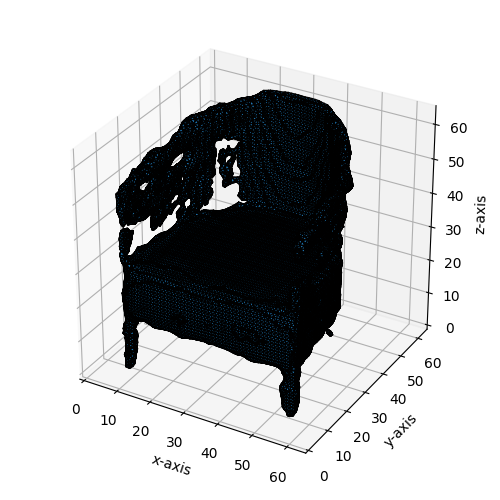

<IPython.core.display.Javascript object>


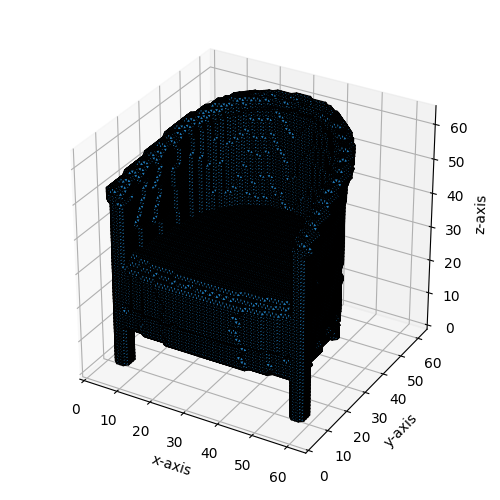

In [13]:
rid = np.random.randint(len(recon))
plot_isosurface(recon[rid], iso_value)
plot_isosurface(gt[rid], 0)